# Тустовое задание на отбор на позицию стажера в отдел структурной биоинформатики BIOCAD 2025

### работу выполнил Калинкин Алексей

## Загрузка данных:

In [1]:
!wget https://life.bsc.es/pid/skempi2/database/download/skempi_v2.csv

--2025-05-04 18:34:55--  https://life.bsc.es/pid/skempi2/database/download/skempi_v2.csv
Resolving life.bsc.es (life.bsc.es)... 84.88.52.107
Connecting to life.bsc.es (life.bsc.es)|84.88.52.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1602208 (1.5M) [text/csv]
Saving to: ‘skempi_v2.csv’

skempi_v2.csv       100%[===================>]   1.53M  2.70MB/s    in 0.6s    

2025-05-04 18:34:56 (2.70 MB/s) - ‘skempi_v2.csv’ saved [1602208/1602208]



## Подготовка данных:

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [2]:
data = pd.read_csv('./skempi_v2.csv', delimiter=';')
data

,#Pdb,Mutation(s)_PDB,Mutation(s)_cleaned,iMutation_Location(s),Hold_out_type,Hold_out_proteins,Affinity_mut (M),Affinity_mut_parsed,Affinity_wt (M),Affinity_wt_parsed,...,koff_mut_parsed,koff_wt (s^(-1)),koff_wt_parsed,dH_mut (kcal mol^(-1)),dH_wt (kcal mol^(-1)),dS_mut (cal mol^(-1) K^(-1)),dS_wt (cal mol^(-1) K^(-1)),Notes,Method,SKEMPI version
0,1CSE_E_I,LI45G,LI38G,COR,Pr/PI,Pr/PI,5.26E-11,5.260000e-11,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
1,1CSE_E_I,LI45S,LI38S,COR,Pr/PI,Pr/PI,8.33E-12,8.330000e-12,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
2,1CSE_E_I,LI45P,LI38P,COR,Pr/PI,Pr/PI,1.02E-07,1.020000e-07,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
3,1CSE_E_I,LI45I,LI38I,COR,Pr/PI,Pr/PI,1.72E-10,1.720000e-10,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
4,1CSE_E_I,LI45D,LI38D,COR,Pr/PI,Pr/PI,1.92E-09,1.920000e-09,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7080,3QIB_ABP_CD,KP9R,KP8R,COR,TCR/pMHC,"TCR/pMHC,1JCK_A_B",2.4E-04,2.400000e-04,5.5E-06,5.500000e-06,...,0.500,2.2E-02,0.022,NaN,NaN,NaN,NaN,NaN,SPR,2
7081,3QIB_ABP_CD,TP12A,TP11A,COR,TCR/pMHC,"TCR/pMHC,1JCK_A_B",>1.1E-03,1.100000e-03,5.5E-06,5.500000e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPR,2
7082,3QIB_ABP_CD,TP12S,TP11S,COR,TCR/pMHC,"TCR/pMHC,1JCK_A_B",3.38E-05,3.380000e-05,5.5E-06,5.500000e-06,...,0.134,2.2E-02,0.022,NaN,NaN,NaN,NaN,NaN,SPR,2
7083,3QIB_ABP_CD,TP12N,TP11N,COR,TCR/pMHC,"TCR/pMHC,1JCK_A_B",4.34E-05,4.340000e-05,5.5E-06,5.500000e-06,...,0.175,2.2E-02,0.022,NaN,NaN,NaN,NaN,NaN,SPR,2


In [3]:
def process_column(string):
    try:
        float(string)
        return string
    except:
        try: 
            float(string[1:])
            return string[1:]
        except:
            return None

In [ ]:
data['Affinity_mut (M)'] = data['Affinity_mut (M)'].apply(process_column)
data['Affinity_wt (M)'] = data['Affinity_wt (M)'].apply(process_column)
data = data[data['Affinity_mut (M)'].notna() & data['Affinity_wt (M)'].notna()]

data['Temperature'] = data['Temperature'].apply(lambda x: float(x[:3]) if type(x) != float else x)

data['Affinity_mut (M)'] = data['Affinity_mut (M)'].apply(float)
data['Affinity_wt (M)'] = data['Affinity_wt (M)'].apply(float)

In [9]:
data = data.copy()
R = 8.314 
data['ddG'] = R*data['Temperature']*np.log(data['Affinity_mut (M)'] - data['Affinity_wt (M)'])

/home/aleksei/miniconda3/envs/torchenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/aleksei/miniconda3/envs/torchenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
data['ddG']

0      -57905.424966
1      -62710.276645
2      -39349.342050
3      -54972.812424
4      -49061.147635
            ...     
7080   -20707.682968
7081   -16890.742163
7082   -25946.741317
7083   -25223.069027
7084   -25255.972194
Name: ddG, Length: 6798, dtype: float64

In [12]:
# оставим только единичные мутации, чтобы обеспечить постоянную форму входных данных для модели
mask3 = data['iMutation_Location(s)'].apply(lambda x: False if ',' in x else True)
data = data[mask3]

In [131]:
data.to_csv('data.csv', index=False)

In [34]:
res_to_code = {
    'A': 0,
    'R': 1,
    'N': 2,
    'D': 3,
    'C': 4,
    'Q': 5,
    'E': 6,
    'G': 7,
    'H': 8,
    'I': 9,
    'L': 10,
    'K': 11,
    'M': 12,
    'F': 13,
    'P': 14,
    'S': 15, 
    'T': 16,
    'W': 17,
    'Y': 18,
    'V': 19
}

location_to_code ={
    'COR': 0,
    'RIM': 1,
    'SUP': 2,
    'SUR': 3,
    'INT': 4,
}

method_to_code = {
    'SPR': 0,
    'FL': 1,
    'IASP': 2,
    'ITC': 3,
    'RA': 4,
    'SFFL': 5,
    'SP': 6,
    'IAFL': 7,
    'ELISA': 8,
    'IARA': 9,
    'KinExA': 10,
    'BI': 11,
    'CSPRIA': 12,
    'ESMA': 13,
    'ELFA': 14,
    'SE': 15, 
    'SFPF': 16,
    'SPR,SFFL': 17,
    'IAGE': 18,
    'EMSA': 19
}

In [133]:
prepared_data = []
for i in data.index:
    if str(data['ddG'][i]) != 'nan' and  str(data['ddG'][i]) != '-inf':
        ID = data['#Pdb'][i][:4]
        path = f'./PDBs/{ID}.pdb'
        mut = data['Mutation(s)_PDB'][i]
        location = data['iMutation_Location(s)'][i]
        method = data['Method'][i]
        orig_res_vector = np.zeros(20)
        mut_res_vector = np.zeros(20)
        location_vector = np.zeros(5)
        method_vector = np.zeros(20)
        orig_res_vector[res_to_code[mut[0]]] = 1 
        mut_res_vector[res_to_code[mut[-1]]] = 1
        location_vector[location_to_code[location]] = 1
        method_vector[method_to_code[method]] = 1
        ddg = data['ddG'][i]
        feature_vector = np.concatenate((orig_res_vector, mut_res_vector, location_vector, method_vector), axis=0)
        prepared_data.append([feature_vector, ddg])



## Обучение

In [162]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature_vector = torch.tensor(self.data[idx][0]).float() 
        target_value = torch.tensor(self.data[idx][1]).float()
        return feature_vector, target_value
    
train_data, test_data = train_test_split(
    prepared_data,
    test_size=0.2,
    random_state=42
)

train_dataset = MyDataset(train_data)
test_dataset = MyDataset(test_data)
    
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

In [163]:
class MyModel(nn.Module):
    def __init__(self, input_size=65, hidden_size=128, output_size=1):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [170]:
def train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device):
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_score = 0
        for X_batch, Y_batch in tqdm(train_dataloader):
            X = X_batch.to(device)
            y = Y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            preds = torch.argmax(logits, dim=1)
            score = sum(preds == y)/len(y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_score += score.item()
        train_losses.append(epoch_loss/len(train_dataloader))

        model.eval()
        epoch_loss = 0
        epoch_score = 0
        with torch.no_grad():
            for X_batch, Y_batch in valid_dataloader:
                X = X_batch.to(device)
                y = Y_batch.to(device)
                logits = model(X)
                loss = criterion(logits, y)
                preds = torch.argmax(logits, dim=1)
                score = sum(preds == y)/len(y)
                epoch_loss += loss.item()
                epoch_score += score.item()
            valid_losses.append(epoch_loss/len(valid_dataloader))
        print(f'Epoch {epoch}:\tloss\tmetric')
        print(f'train\t{train_losses[-1]}')
        print(f'valid\t{valid_losses[-1]}')

    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel('epoch')
    plt.plot(train_losses, label='train_loss')
    plt.plot(valid_losses, label='valid_loss')
    plt.legend()

    return model


In [171]:
device = torch.device("cuda")
model = MyModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

100%|██████████| 94/94 [00:00<00:00, 259.76it/s]


Epoch 0:	loss	metric
train	2102678202.5531914
valid	2049001818.6666667


100%|██████████| 94/94 [00:00<00:00, 356.13it/s]


Epoch 1:	loss	metric
train	2101947430.1276596
valid	2046775514.6666667


100%|██████████| 94/94 [00:00<00:00, 337.41it/s]


Epoch 2:	loss	metric
train	2099057574.1276596
valid	2042566661.3333333


100%|██████████| 94/94 [00:00<00:00, 347.92it/s]


Epoch 3:	loss	metric
train	2098723984.3404255
valid	2036229920.0


100%|██████████| 94/94 [00:00<00:00, 361.71it/s]


Epoch 4:	loss	metric
train	2084728938.212766
valid	2027785578.6666667


100%|██████████| 94/94 [00:00<00:00, 338.24it/s]


Epoch 5:	loss	metric
train	2088896680.8510637
valid	2017210757.3333333


100%|██████████| 94/94 [00:00<00:00, 352.48it/s]


Epoch 6:	loss	metric
train	2063170197.787234
valid	2004803530.6666667


100%|██████████| 94/94 [00:00<00:00, 293.95it/s]


Epoch 7:	loss	metric
train	2051820971.5744681
valid	1990738112.0


100%|██████████| 94/94 [00:00<00:00, 290.38it/s]


Epoch 8:	loss	metric
train	2038437030.1276596
valid	1974990581.3333333


100%|██████████| 94/94 [00:00<00:00, 315.91it/s]


Epoch 9:	loss	metric
train	2017397504.0
valid	1957707584.0


100%|██████████| 94/94 [00:00<00:00, 262.99it/s]


Epoch 10:	loss	metric
train	2005622380.93617
valid	1938907568.0


100%|██████████| 94/94 [00:00<00:00, 215.40it/s]


Epoch 11:	loss	metric
train	1980896563.744681
valid	1918808949.3333333


100%|██████████| 94/94 [00:00<00:00, 284.14it/s]


Epoch 12:	loss	metric
train	1964416027.2340426
valid	1897443274.6666667


100%|██████████| 94/94 [00:00<00:00, 347.01it/s]


Epoch 13:	loss	metric
train	1941989814.468085
valid	1874861130.6666667


100%|██████████| 94/94 [00:00<00:00, 343.51it/s]


Epoch 14:	loss	metric
train	1914542306.0425532
valid	1851189421.3333333


100%|██████████| 94/94 [00:00<00:00, 350.40it/s]


Epoch 15:	loss	metric
train	1892413958.8085105
valid	1826567762.6666667


100%|██████████| 94/94 [00:00<00:00, -557.97it/s]


Epoch 16:	loss	metric
train	1869598718.6382978
valid	1800885861.3333333


100%|██████████| 94/94 [00:00<00:00, 345.46it/s]


Epoch 17:	loss	metric
train	1835715551.319149
valid	1774355106.6666667


100%|██████████| 94/94 [00:00<00:00, 327.29it/s]


Epoch 18:	loss	metric
train	1807802184.1702127
valid	1747114874.6666667


100%|██████████| 94/94 [00:00<00:00, 313.31it/s]


Epoch 19:	loss	metric
train	1781660332.93617
valid	1719008184.0


100%|██████████| 94/94 [00:00<00:00, 349.18it/s]


Epoch 20:	loss	metric
train	1761456917.787234
valid	1690226373.3333333


100%|██████████| 94/94 [00:00<00:00, 314.62it/s]


Epoch 21:	loss	metric
train	1725980172.255319
valid	1660713496.0


100%|██████████| 94/94 [00:00<00:00, 302.84it/s]


Epoch 22:	loss	metric
train	1697817809.7021277
valid	1630706029.3333333


100%|██████████| 94/94 [00:00<00:00, 297.41it/s]


Epoch 23:	loss	metric
train	1663634595.4042554
valid	1600067117.3333333


100%|██████████| 94/94 [00:00<00:00, 277.44it/s]


Epoch 24:	loss	metric
train	1629792089.8723404
valid	1569073757.3333333


100%|██████████| 94/94 [00:00<00:00, 294.42it/s]


Epoch 25:	loss	metric
train	1607470236.5957446
valid	1537625312.0


100%|██████████| 94/94 [00:00<00:00, 244.94it/s]


Epoch 26:	loss	metric
train	1564251422.6382978
valid	1505700498.6666667


100%|██████████| 94/94 [00:00<00:00, 268.92it/s]


Epoch 27:	loss	metric
train	1539448483.4042554
valid	1473581962.6666667


100%|██████████| 94/94 [00:00<00:00, 322.74it/s]


Epoch 28:	loss	metric
train	1500060539.9148936
valid	1441139922.6666667


100%|██████████| 94/94 [00:00<00:00, 350.92it/s]


Epoch 29:	loss	metric
train	1472683765.106383
valid	1408536986.6666667


100%|██████████| 94/94 [00:00<00:00, 353.41it/s]


Epoch 30:	loss	metric
train	1444620339.744681
valid	1375614304.0


100%|██████████| 94/94 [00:00<00:00, 361.10it/s]


Epoch 31:	loss	metric
train	1407241149.2765958
valid	1342544837.3333333


100%|██████████| 94/94 [00:00<00:00, 254.82it/s]


Epoch 32:	loss	metric
train	1375342768.3404255
valid	1309378976.0


100%|██████████| 94/94 [00:00<00:00, 254.71it/s]


Epoch 33:	loss	metric
train	1335082255.6595745
valid	1276301989.3333333


100%|██████████| 94/94 [00:00<00:00, 262.99it/s]


Epoch 34:	loss	metric
train	1304088817.0212767
valid	1243245957.3333333


100%|██████████| 94/94 [00:00<00:00, 284.98it/s]


Epoch 35:	loss	metric
train	1263975799.1489363
valid	1210081570.6666667


100%|██████████| 94/94 [00:00<00:00, 309.02it/s]


Epoch 36:	loss	metric
train	1239240117.787234
valid	1177156501.3333333


100%|██████████| 94/94 [00:00<00:00, 305.14it/s]


Epoch 37:	loss	metric
train	1213990322.3829787
valid	1144138472.0


100%|██████████| 94/94 [00:00<00:00, 302.14it/s]


Epoch 38:	loss	metric
train	1167904627.744681
valid	1111292101.3333333


100%|██████████| 94/94 [00:00<00:00, 329.39it/s]


Epoch 39:	loss	metric
train	1133278158.9787233
valid	1078741329.3333333


100%|██████████| 94/94 [00:00<00:00, 295.66it/s]


Epoch 40:	loss	metric
train	1100359827.06383
valid	1046312606.6666666


100%|██████████| 94/94 [00:00<00:00, 333.68it/s]


Epoch 41:	loss	metric
train	1075739104.0
valid	1014188169.3333334


100%|██████████| 94/94 [00:00<00:00, 326.81it/s]


Epoch 42:	loss	metric
train	1035120501.106383
valid	982245810.6666666


100%|██████████| 94/94 [00:00<00:00, 312.87it/s]


Epoch 43:	loss	metric
train	1001050316.9361702
valid	950660988.0


100%|██████████| 94/94 [00:00<00:00, 310.52it/s]


Epoch 44:	loss	metric
train	971968763.2340425
valid	919614676.0


100%|██████████| 94/94 [00:00<00:00, 273.96it/s]


Epoch 45:	loss	metric
train	943441826.0425532
valid	888745074.6666666


100%|██████████| 94/94 [00:00<00:00, 289.70it/s]


Epoch 46:	loss	metric
train	908295351.1489362
valid	858341084.0


100%|██████████| 94/94 [00:00<00:00, 286.79it/s]


Epoch 47:	loss	metric
train	881712120.5106384
valid	828434988.0


100%|██████████| 94/94 [00:00<00:00, 287.48it/s]


Epoch 48:	loss	metric
train	845172791.8297873
valid	798813300.0


100%|██████████| 94/94 [00:00<00:00, 287.74it/s]


Epoch 49:	loss	metric
train	823408004.0851064
valid	769856640.0


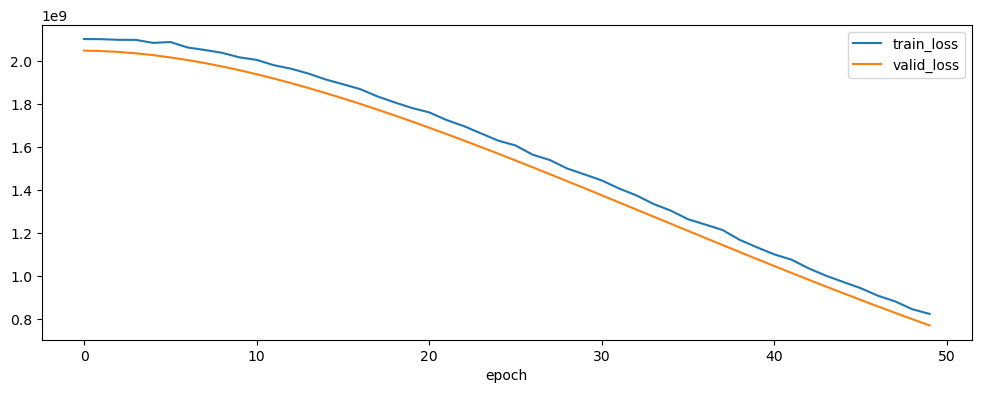

In [172]:
model = train(model, optimizer, criterion, epochs, train_loader, test_loader, device)